# Conditional generation via Bayesian optimization in latent space

## Introduction

I recently read [Automatic Chemical Design Using a Data-Driven Continuous Representation of Molecules](https://arxiv.org/abs/1610.02415) by Gómez-Bombarelli et. al.<sup>[1]</sup> and it motivated me to experiment with the approaches described in the paper. 

Here's a brief summary of the paper. It describes how they use a variational autoencoder<sup>[2]</sup> for generating new chemical compounds with properties that are of interest for drug discovery. For training, they used a large database of chemical compounds whose properties of interest are known. The variational autoencoder can encode compounds into 196-dimensional latent space representations.

By sampling from the continuous latent space new compounds can be generated e.g. by sampling near a known compound to generate slight variations of it or by interpolating between more distant compounds. By simply autoencoding chemical compounds, however, they were not able organize latent space w.r.t. properties of interest.

To additionally organize latent space w.r.t. these properties they jointly trained the variational autoencoder with a predictor that predicts these properties from latent space representations. Joint training with a predictor resulted in a latent space that reveals a gradient of these properties. This gradient can then be used to drive search for new chemical compounds into regions of desired properties. The following figure, copied from the paper<sup>[1]</sup>, summarizes the approach.

![vae-chem](images/vae-opt/vae-chem.png)

For representing compounds in structure space, they use [SMILES](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system) strings which can be converted to and from structural representations using standard computational chemistry software. For the encoder network, they experimented with both, 1D-CNNs and RNNs, for the decoder network they used a RNN. Architecure details are described in the paper. The predictor is a small dense neural network. For optimization in latent space i.e. for navigating into regions of desired properties they use a Bayesian optimization approach with Gaussian processes as surrogate model. 

The authors open-sourced their [chemical variational autoencoder](https://github.com/aspuru-guzik-group/chemical_vae) but didn't publish code related to Bayesian optimization, at least not at the time of writing this article. So I decided to start some experiments but on a toy dataset that is not related to chemistry at all: the [MNIST handwritten digits dataset](https://en.wikipedia.org/wiki/MNIST_database). All methods described in the paper can be applied in this context too and results are easier to visualize and probably easier to grasp for people not familiar with chemistry. The only property associated with the MNIST dataset is the label or value of the digits. 

In the following, it will be shown how to conditionally generate new digits by following a gradient in latent space. In other words, it will be shown how to navigate into regions of latent space that decode into digit images of desired target label. I'm also going to adress the following questions:

- How does joint training with a predictor change the latent space of a variational autoencoder?
- How can useful optimization objectives be designed?
- How can application of Bayesian optimization methods be justified?
- What are possible alternatives to this approach? 

I'll leave experiments with the chemical compounds dataset and the public chemical VAE for another article. The following assumes some basic familiarity with [variational autoencoders](https://nbviewer.jupyter.org/github/krasserm/bayesian-machine-learning/blob/dev/autoencoder-applications/variational_autoencoder.ipynb), [Bayesian otpimization](http://nbviewer.jupyter.org/github/krasserm/bayesian-machine-learning/blob/dev/bayesian-optimization/bayesian_optimization.ipynb) and [Gaussian processes](http://nbviewer.jupyter.org/github/krasserm/bayesian-machine-learning/blob/dev/gaussian-processes/gaussian_processes.ipynb). For more information on these topics you may want to read the linked articles.

## Architecture

The high-level architecture of the joint VAE-predictor model is shown in the following figure.

![model](images/vae-opt/model.png)

### Encoder

The encoder is a CNN, identical to the one presented in the the [variational autoencoder](https://nbviewer.jupyter.org/github/krasserm/bayesian-machine-learning/blob/dev/autoencoder-applications/variational_autoencoder.ipynb) notebook.

![encoder](images/vae-opt/encoder.png) 

### Decoder

The decoder is a CNN, identical to the one presented in the the [variational autoencoder](https://nbviewer.jupyter.org/github/krasserm/bayesian-machine-learning/blob/dev/autoencoder-applications/variational_autoencoder.ipynb) notebook.

![decoder](images/vae-opt/decoder.png)

### Predictor

The predictor is a dense network with two hidden layers that predicts the probabilities of MNIST image labels 0-9 from the mean i.e. `t_mean` of the variational Gaussian distribution (details below). `t_mean` is one of the encoder outputs. The output layer of the predictor is a softmax layer with 10 units.

![predictor](images/vae-opt/predictor.png)

## Implementation

We will use a 2-dimensional latent space for easier visualization. By default, this notebook loads pre-trained models. If you want to train the models yourself set `use_pretrained` to `False`. Expects about 15 minutes on a GPU for training and much longer on a CPU.

In [10]:
# Use pre-trained models by default
use_pretrained = False

# Dimensionality of latent space
latent_dim = 2

# Mini-batch size used for training
batch_size = 64

Code for the encoder and decoder have already been presented [elsewhere](https://nbviewer.jupyter.org/github/krasserm/bayesian-machine-learning/blob/dev/autoencoder-applications/variational_autoencoder.ipynb), so only code for the predictor is shown here (see [variational_autoencoder_opt_util.py](variational_autoencoder_opt_util.py) for other function definitions):

In [11]:
import keras

from keras import layers
from keras.models import Model

def create_predictor():
    '''
    Creates a classifier that predicts digit image labels 
    from latent variables.
    '''
    predictor_input = layers.Input(shape=(latent_dim,), name='t_mean')
    
    x = layers.Dense(128, activation='relu')(predictor_input)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(10, activation='softmax', name='label_probs')(x)

    return Model(predictor_input, x, name='predictor')

The following composes the joint VAE-predictor model. Note that input to the predictor is the mean i.e. `t_mean` of the variational distribution, not a sample from it.

In [12]:
from variational_autoencoder_opt_util import *

encoder = create_encoder(latent_dim)
decoder = create_decoder(latent_dim)
sampler = create_sampler()
predictor = create_predictor()

x = layers.Input(shape=image_shape, name='image')
t_mean, t_log_var = encoder(x)
t = sampler([t_mean, t_log_var])
t_decoded = decoder(t)
t_predicted = predictor(t_mean)

model = Model(x, [t_decoded, t_predicted], name='composite')

## Dataset

In [13]:
from keras.datasets import mnist
from keras.utils import to_categorical

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
y_train_cat = to_categorical(y_train)

x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))
y_test_cat = to_categorical(y_test)  

## Training

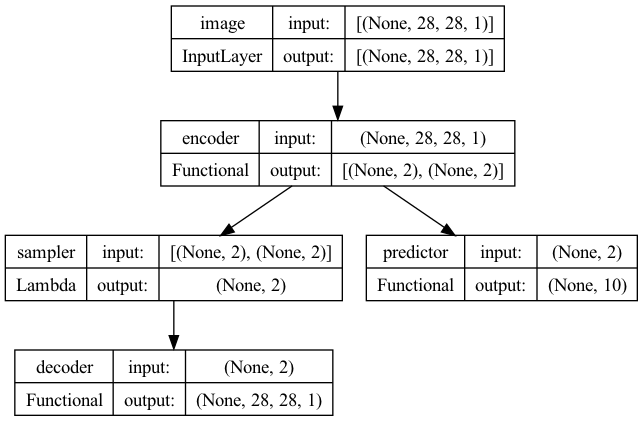

In [14]:
keras.utils.plot_model(model, show_shapes=True)

In [5]:
model.summary()

Model: "composite"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 encoder (Functional)        [(None, 2),                  494244    ['image[0][0]']               
                              (None, 2)]                                                          
                                                                                                  
 sampler (Lambda)            (None, 2)                    0         ['encoder[0][0]',             
                                                                     'encoder[0][1]']             
                                                                                          

In [15]:
from keras import backend as K
from keras.models import load_model

def vae_loss(x, t_decoded):
    '''
    Negative variational lower bound used as loss function for 
    training the variational autoencoder on the MNIST dataset.
    '''
    # Reconstruction loss
    rc_loss = K.sum(K.binary_crossentropy(
        K.batch_flatten(x), 
        K.batch_flatten(t_decoded)), axis=-1)

    # Regularization term (KL divergence)
    kl_loss = -0.5 * K.sum(1 + t_log_var \
                             - K.square(t_mean) \
                             - K.exp(t_log_var), axis=-1)
    
    return K.mean(rc_loss + kl_loss)

if use_pretrained:
    # Load VAE that was jointly trained with a 
    # predictor returned from create_predictor()
    model = load_model('models/vae-opt/vae-predictor-softmax.h5', 
                        custom_objects={'vae_loss': vae_loss})
else:
    model.compile(optimizer='rmsprop', 
                  loss=[vae_loss, 'categorical_crossentropy'],
                  loss_weights=[1.0, 20.0])
    
    model.fit(x=x_train, 
              y=[x_train, y_train_cat],
              epochs=2,
              shuffle=True,
              batch_size=batch_size,
              validation_data=(x_test, [x_test, y_test_cat]), verbose=2)

Epoch 1/2


TypeError: in user code:

    File "/Users/CVC/anaconda3/envs/bml/lib/python3.10/site-packages/keras/src/engine/training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "/Users/CVC/anaconda3/envs/bml/lib/python3.10/site-packages/keras/src/engine/training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/CVC/anaconda3/envs/bml/lib/python3.10/site-packages/keras/src/engine/training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "/Users/CVC/anaconda3/envs/bml/lib/python3.10/site-packages/keras/src/engine/training.py", line 1081, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/CVC/anaconda3/envs/bml/lib/python3.10/site-packages/keras/src/engine/training.py", line 1139, in compute_loss
        return self.compiled_loss(
    File "/Users/CVC/anaconda3/envs/bml/lib/python3.10/site-packages/keras/src/engine/compile_utils.py", line 282, in __call__
        metric_obj.update_state(
    File "/Users/CVC/anaconda3/envs/bml/lib/python3.10/site-packages/keras/src/utils/metrics_utils.py", line 77, in decorated
        update_op = update_state_fn(*args, **kwargs)
    File "/Users/CVC/anaconda3/envs/bml/lib/python3.10/site-packages/keras/src/metrics/base_metric.py", line 140, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "/Users/CVC/anaconda3/envs/bml/lib/python3.10/site-packages/keras/src/metrics/base_metric.py", line 509, in update_state  **
        sample_weight = tf.__internal__.ops.broadcast_weights(
    File "/Users/CVC/anaconda3/envs/bml/lib/python3.10/site-packages/keras/src/engine/keras_tensor.py", line 285, in __array__
        raise TypeError(

    TypeError: You are passing KerasTensor(type_spec=TensorSpec(shape=(), dtype=tf.float32, name=None), name='Placeholder:0', description="created by layer 'tf.cast_3'"), an intermediate Keras symbolic input/output, to a TF API that does not allow registering custom dispatchers, such as `tf.cond`, `tf.function`, gradient tapes, or `tf.map_fn`. Keras Functional model construction only supports TF API calls that *do* support dispatching, such as `tf.math.add` or `tf.reshape`. Other APIs cannot be called directly on symbolic Kerasinputs/outputs. You can work around this limitation by putting the operation in a custom Keras layer `call` and calling that layer on this symbolic input/output.


## Results

### Latent space

This sections addresses the question 

> How does joint training with a predictor change the latent space of a variational autoencoder? 

To answer, three models have been trained:

- A VAE as described above but without a predictor (`model_predictor_off`).
- A VAE jointly trained with a classifier as predictor (`model_predictor_softmax`). This is the model described above where the predictor predicts the probabilities of labels 0-9 from encoded MNIST images.
- A VAE as described above but jointly trained with a regressor as predictor (`model_predictor_linear`). The predictor of this model is trained to predict digit values on a continuous scale i.e. predictions are floating point numbers that can also be less than 0 and greater than 9. See also `create_predictor_linear` in [variational_autoencoder_opt_util.py](variational_autoencoder_opt_util.py).

In [ ]:
model_predictor_softmax = model

model_predictor_linear = load_model('models/vae-opt/vae-predictor-linear.h5', 
                                    custom_objects={'vae_loss': vae_loss})
model_predictor_off = load_model('models/vae-opt/vae-predictor-off.h5', 
                                 custom_objects={'vae_loss': vae_loss})

The following plots show the latent spaces of these three models and the distribution of the validation dataset `x_test` in these spaces. Validation data points are colored by their label.

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline

def encode(x, model):
    return model.get_layer('encoder').predict(x)[0]

ts = [encode(x_test, model_predictor_off),
      encode(x_test, model_predictor_softmax),
      encode(x_test, model_predictor_linear)]

titles = ['VAE latent space without predictor',
          'VAE latent space with classifier',
          'VAE latent space with regressor']

fig = plt.figure(figsize=(15, 4))
cmap = plt.get_cmap('viridis', 10)

for i, t in enumerate(ts):
    plt.subplot(1, 3, i+1)
    im = plt.scatter(t[:, 0], t[:, 1], c=y_test, 
                     cmap=cmap, 
                     vmin=-0.5, vmax=9.5, 
                     marker='o', s=0.4)
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)
    plt.title(titles[i])

fig.subplots_adjust(right=0.8)
fig.colorbar(im, fig.add_axes([0.82, 0.13, 0.02, 0.74]), ticks=range(10));

One can clearly see that the latent space of models with a predictor (middle and right plot) has more structure i.e. less overlap of regions with different labels than the latent space of the model without a predictor (left plot). Furthermore, when the predictor is a regressor it establishes a gradient in latent space. The right plot clearly shows a gradient from upper-right (lower vaues) to lower-left (higher values). 

This is exactly what the authors of the paper wanted to achieve: additionally organizing the latent space w.r.t. certain continuous properties so that gradient-based navigation into regions of desired properties becomes possible. If you want to train a model yourself with a regressor as predictor you should make the following modifications to the setup above:

In [ ]:
# ...
predictor = create_predictor_linear(latent_dim)
# ...

model.compile(optimizer='rmsprop', 
              loss=[vae_loss, 'mean_squared_error'],
              loss_weights=[1.0, 20.0])

model.fit(x=x_train, 
          y=[x_train, y_train_cat],
          epochs=15,
          shuffle=True,
          batch_size=batch_size,
          validation_data=(x_test, [x_test, y_test_cat]))

Note that in the case of the MNIST dataset the latent space in the left plot is already sufficiently organized to navigate into regions of desired labels. However, this is not the case for the chemical compound dataset (see paper for details) so that further structuring is required. For the MNIST dataset, the goal is merely to demonstrate that further structuring is possible too. In the following we will use the model that uses a classifier as predictor i.e. the model corresponding to the middle plot.

### Optimization objectives

> How can useful optimization objectives be designed?

First of all, the optimization objective must be a function of the desired target label in addition to latent variable $\mathbf{t}$. For example, if the desired target label is 5 the optimization objective must have an optimum in that region of the latent space where images with a 5 are located. Also remember that the variational distributions i.e. the distributions of codes in latent space have been regularized to be close to the standard normal distribution during model training (see *regularization term* in `vae_loss`). This regularization term should also be considered in the optimization objective to avoid directing search too far from the origin.

Hence the optimization objective should not only reflect the probability that a sample corresponds to an image of desired target label but also the standard normal probability distribution. In the following, we will use an optimization objective $f$ that is the negative logarithm of the product of these two terms:

$$
f(\mathbf{t}, target) = - \log p(y=target \lvert \mathbf{t}) - \log \mathcal{N}(\mathbf{t} \lvert \mathbf{0}, \mathbf{I}) \tag{1}
$$

where $y$ follows a categorical distribution and $p(y=target \lvert \mathbf{t})$ is the probability that $y$ has the desired target value given latent vector $\mathbf{t}$. I'll show two alternatives for computing $p(y=target \lvert \mathbf{t})$. The first alternative simply uses the output of the predictor. The corresponding optimization objective is visualized in the following figure.

In [ ]:
from matplotlib.colors import LogNorm
from scipy.stats import multivariate_normal

predictor = model.get_layer('predictor')

rx, ry = np.arange(-4, 4, 0.10), np.arange(-4, 4, 0.10)
gx, gy = np.meshgrid(rx, ry)

t_flat = np.c_[gx.ravel(), gy.ravel()]
y_flat = predictor.predict(t_flat)

mvn = multivariate_normal(mean=[0, 0], cov=[[1, 0], [0, 1]])
nll_prior = -mvn.logpdf(t_flat).reshape(-1, 1)

def nll_predict(i):
    '''Optimization objective based on predictor output.'''
    return nll_prior - np.log(y_flat[:,i] + 1e-8).reshape(-1, 1)

plot_nll(gx, gy, nll_predict)

One can clearly see how the minima in these plots overlap with the different target value regions in the previous figure (see section [Latent space](#Latent-space)). We could now use a gradient-based optimizer for navigating into regions of high log-likelihood i.e. low negative log-likelihood and sample within that region to conditionally generate new digits of the desired target value.

Another alternative is to design an optimization objective that can also include "external" results. To explain, let's assume for a moment that we are again in the latent space of chemical compounds. External results in this context can mean experimental results or externally computed results obtained for new compounds sampled from latent space. For example, experimental results can come from expensive drug discovery experiments and externally computed results from computational chemistry software.

For working with external results we can use a Gaussian process model (a regression model) initialized with samples from the training set and let a Bayesian optimization algorithm propose new samples from latent space. Then we gather external results for these proposals and update the Gaussian process model with it. Based on the updated model, Bayesian optimization can now propose new samples. A Bayesian optimization approach is especially useful if experimental results are expensive to obtain as it is designed to optimize the objective in a minimum number of steps. This should answer the question

> How can application of Bayesian optimization methods be justified?

But how can we transfer these ideas to the MNIST dataset? One option is to decode samples from latent space to real images and then let a separate MNIST image classifier compute the probability that a decoded image shows a digit equal to the desired target. For that purpose we use a small CNN that was trained to achieve 99.2% validation accuracy on `x_test`, enough for our purposes. 

In [ ]:
if use_pretrained:
    classifier = load_model('models/vae-opt/classifier.h5')
else:
    classifier = create_classifier()
    classifier.compile(optimizer='rmsprop', 
                       loss='categorical_crossentropy', 
                       metrics=['accuracy'])

    classifier.fit(x_train, 
                   y_train_cat, 
                   epochs=5, 
                   shuffle=True,
                   batch_size=batch_size, 
                   validation_data=(x_test, y_test_cat), verbose=2)

If we combine the negative log-likelihood computed with the separate image classifier with the regularization term mentioned before, we obtain the following optimization objective:

In [ ]:
decoder = model.get_layer('decoder')

# Decode latent vector into image
d_flat = decoder.predict(t_flat)

# Predict probabilities with separate classifier
y_flat = classifier.predict(d_flat)

def nll_decode_classify(i):
    '''Optimization objective based on separate image classifier output.'''
    return nll_prior - np.log(y_flat[:,i] + 1e-8).reshape(-1, 1)

plot_nll(gx, gy, nll_decode_classify)

The locations of the minima closely match those of the previous optimization objective but the new optimization objective is more fuzzy. It also shows moderately low negative log-likelihood in regions outside of the desired target as well as in regions that are sparsely populated by validation examples. Anyway, let's use it and see if we can achieve reasonable results.

### Bayesian optimization

For Bayesian optimization, we use [GPyOpt](http://sheffieldml.github.io/GPyOpt/) with more or less default settings and constrain the the search space as given by `bounds` below. Note that the underlying Gaussian process model is initialized with only two random samples from latent space.

In [ ]:
import GPyOpt
from GPyOpt.methods import BayesianOptimization

def nll(t, target):
    '''
    Bayesian optimization objective.
    '''
    # Decode latent vector into image
    decoded = decoder.predict(t)
    # Predict probabilities with separate classifier
    c_probs = classifier.predict(decoded)

    nll_prior = -mvn.logpdf(t).reshape(-1, 1)
    nll_pred = -np.log(c_probs[:,target] + 1e-8).reshape(-1, 1)
    
    return nll_prior + nll_pred

bounds = [{'name': 't1', 'type': 'continuous', 'domain': (-4.0, 4.0)},
          {'name': 't2', 'type': 'continuous', 'domain': (-4.0, 4.0)}]

def optimizer_for(target):
    
    def nll_target(t):
        return nll(t, target)

    return BayesianOptimization(f=nll_target, 
                                domain=bounds,
                                model_type='GP',
                                acquisition_type ='EI',
                                acquisition_jitter = 0.01,
                                initial_design_numdata = 2,
                                exact_feval=False)

We start by running Bayesian optimization for a desired target value of 4 and then visualize the Gaussian process posterior mean, variance and the acquisition function using the built-in `plot_acquisition()` method.

In [ ]:
optimizer = optimizer_for(target=4)
optimizer.run_optimization(max_iter=50)
optimizer.plot_acquisition()

By comparing with previous figures, we can see that most samples are located around the minimum corresponding to target value 4 (left plot). The acquisition function has high values in this region (right plot). Because Bayesian optimization makes a compromise between *exploration* of regions with high uncertainty and *exploitation* of regions with (locally) optimal values high acquisition function values also exist in regions outside the desired target value. This is also the reason why some samples are broadly scattered across the search space. We finally have to verify that the samples with the lowest optimization objective values actually correspond to images with number 4.

In [ ]:
def plot_top(optimizer, num=10):
    top_idx = np.argsort(optimizer.Y, axis=0).ravel()
    top_y = optimizer.Y[top_idx]
    top_x = optimizer.X[top_idx]
    top_dec = np.squeeze(decoder.predict(top_x), axis=-1)

    plt.figure(figsize=(20, 2))
    for i in range(num):
        plt.subplot(1, num, i + 1)
        plt.imshow(top_dec[i], cmap='Greys_r')
        plt.title(f'{top_y[i,0]:.2f}')
        plt.axis('off')

In [ ]:
plot_top(optimizer)

Indeed, they do! The numbers on top of the images are the optimization objective values of the corresponding points in latent space. To generate more images of desired target value we also could select the top scoring samples and continue sampling in a more or less narrow region around them (not shown here). How does conditional sampling for other desired target values work?

In [ ]:
optimizer = optimizer_for(target=3)
optimizer.run_optimization(max_iter=50)
plot_top(optimizer)

In [ ]:
optimizer = optimizer_for(target=2)
optimizer.run_optimization(max_iter=50)
plot_top(optimizer)

In [ ]:
optimizer = optimizer_for(target=5)
optimizer.run_optimization(max_iter=50)
plot_top(optimizer)

In [ ]:
optimizer = optimizer_for(target=9)
optimizer.run_optimization(max_iter=50)
plot_top(optimizer)

This looks pretty good! Also note how for targets 3 and 5 the negative log-likelihood significantly increases for images that are hard to be recognized as their desired targets.

## Alternatives

> What are possible alternatives to this approach?

The approach presented here is one possible approach for conditionally generating images i.e. images with desired target values. In the case of MNIST images, this is actually a very expensive approach. A conditional variational autoencoder<sup>[3]</sup> (CVAE) would be a much better choice here. Anyway, the goal was to demonstrate the approach taken in the paper<sup>[1]</sup> and it worked reasonably well on the MNIST dataset too.

Another interesting approach is described in \[4\]. The proposed approach identifies regions in latent space with desired properties without training the corresponding models with these properties in advance. This should help to prevent expensive model retraining and allows post-hoc learning of so-called *latent constraints*, value functions that identify regions in latent space that generate outputs with desired properties. Definitely one of my next papers to read.

## References

- \[1\] Rafael Gómez-Bombarelli et. al. [Automatic chemical design using a data-driven continuous representation of molecules](https://arxiv.org/abs/1610.02415).  
- \[2\] Diederik P Kingma, Max Welling [Auto-Encoding Variational Bayes](https://arxiv.org/abs/1312.6114).  
- \[3\] Carl Doersch [Tutorial on Variational Autoencoders](https://arxiv.org/abs/1606.05908).  
- \[4\] Jesse Engel et. al. [Latent Constraints: Learning to Generate Conditionally from Unconditional Generative Models](https://arxiv.org/abs/1711.05772).  